Model Evaluation:
Accuracy: 0.98
Precision: 0.88
Recall: 0.70
F1-Score: 0.78


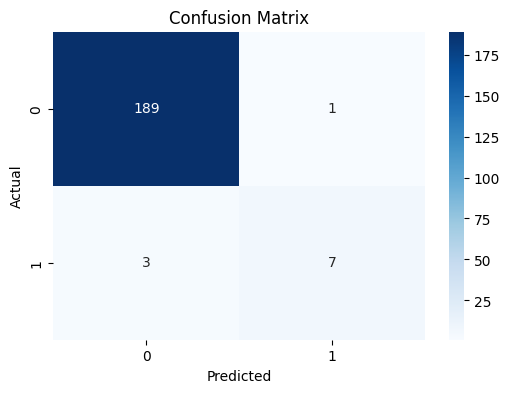

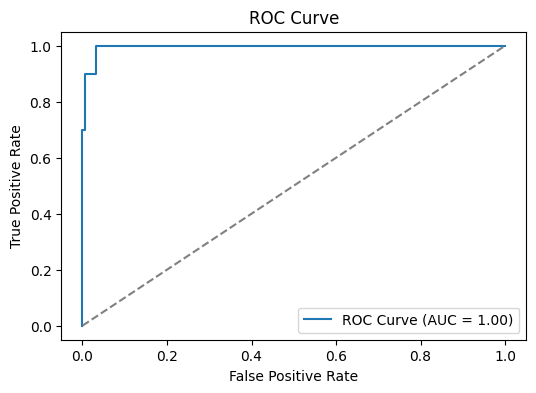

<Figure size 1000x600 with 0 Axes>

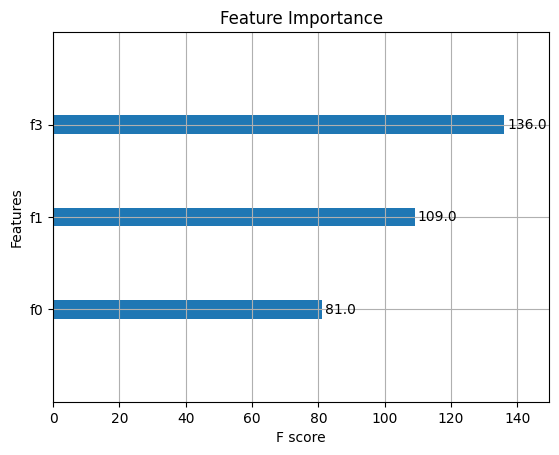

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.ensemble import IsolationForest
import os

# Load and preprocess data
def load_data():
    logon_data = pd.read_csv('/content/r1/logon.csv')
    logon_data['date'] = pd.to_datetime(logon_data['date'])
    logon_data['hour'] = logon_data['date'].dt.hour
    logon_data['after_hours'] = logon_data['hour'].apply(lambda x: 1 if x < 8 or x > 18 else 0)
    logon_data['logon_count'] = logon_data.groupby('user')['user'].transform('count')

    device_data = pd.read_csv('/content/r1/device.csv')
    device_data['date'] = pd.to_datetime(device_data['date'])
    device_data['thumb_drive_usage'] = device_data['activity'].apply(lambda x: 1 if x == 'connect' else 0)
    device_data['thumb_drive_count'] = device_data.groupby('user')['thumb_drive_usage'].transform('sum')

    http_data = pd.read_csv('/content/r1/http.csv', header=None, names=['id', 'date', 'user', 'pc', 'url'])
    http_data['date'] = pd.to_datetime(http_data['date'])
    http_data['url_count'] = http_data.groupby('user')['url'].transform('count')

    ldap_folder = '/content/r1/LDAP'
    ldap_files = [os.path.join(ldap_folder, file) for file in os.listdir(ldap_folder) if file.endswith('.csv')]
    ldap_data = pd.concat([pd.read_csv(file) for file in ldap_files], ignore_index=True)
    ldap_data['role'] = ldap_data['Role'].apply(lambda x: 1 if x == 'IT Admin' else 0)
    ldap_data.rename(columns={'user_id': 'user'}, inplace=True)
    ldap_data = ldap_data[['user', 'role']]
    ldap_data.drop_duplicates(subset=['user'], inplace=True)

    # Aggregate features per user
    logon_agg = logon_data.groupby('user').agg(
        total_logons=('logon_count', 'max'),
        after_hours_logons=('after_hours', 'sum')
    ).reset_index()

    device_agg = device_data.groupby('user').agg(
        thumb_drive_count=('thumb_drive_count', 'max')
    ).reset_index()

    http_agg = http_data.groupby('user').agg(
        url_count=('url_count', 'max')
    ).reset_index()

    # Merge all datasets
    merged_data = logon_agg.merge(device_agg, on='user', how='left')
    merged_data = merged_data.merge(http_agg, on='user', how='left')
    merged_data = merged_data.merge(ldap_data, on='user', how='left')
    merged_data = merged_data.fillna(0)

    return merged_data

# Generate labels using Isolation Forest
def generate_labels(data):
    features = ['total_logons', 'after_hours_logons', 'thumb_drive_count', 'url_count', 'role']
    X = data[features]

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_forest.fit(X_scaled)

    # Predict anomalies
    data['is_anomaly'] = iso_forest.predict(X_scaled)
    data['is_anomaly'] = data['is_anomaly'].apply(lambda x: 1 if x == -1 else 0)  # Convert to binary labels

    return data, scaler

# Train XGBoost model
def train_model(data):
    features = ['total_logons', 'after_hours_logons', 'thumb_drive_count', 'url_count', 'role']
    X = data[features]
    y = data['is_anomaly']

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Train XGBoost model
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    return model, X_test, y_test, scaler

# Load data
data = load_data()

# Generate labels using Isolation Forest
data, scaler = generate_labels(data)

# Train XGBoost model
model, X_test, y_test, scaler = train_model(data)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model Evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='weight', max_num_features=10)
plt.title("Feature Importance")
plt.show()